In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
pd.set_option("display.max_columns", 200)


In [2]:
#Load Facility (Toilets)
#23-24
df_fac = pd.read_csv(
    "100_fac_23.csv",
    usecols=['pseudocode', 'total_boys_func_toilet', 'total_girls_func_toilet'],
    dtype={'pseudocode':'int64'}
)

#Load Teacher Data (now with qualification columns)
#23-24
tch_cols = [
    'pseudocode', 'total_tch',
    'below_graduate', 'graduate', 'post_graduate_and_above'
]

df_tch = pd.read_csv(
    "100_tch_23.csv",
    usecols=lambda c: c in tch_cols,   #loads those that exist; skips if missing
    dtype={'pseudocode':'int64'}
)

#if any qualification columns are missing in the file, create them as 0
for c in ['below_graduate','graduate','post_graduate_and_above']:
    if c not in df_tch.columns:
        df_tch[c] = 0


#Load Profile (Management + Location)
#23-24
df_prof = pd.read_csv(
    "100_prof1_23.csv",
    usecols=['pseudocode', 'managment', 'rural_urban'],
    dtype={'pseudocode':'int64'}
)

#Load Enrolment (Base year: 2023-24)
df_enr1_2324 = pd.read_csv("100_enr1_23.csv",
                            dtype={'pseudocode':'int64'})

#Load Enrolment (Next year: 2024-25)
df_enr1_2425 = pd.read_csv("100_enr1_24.csv",
                            dtype={'pseudocode':'int64'})

print("All files loaded successfully")


All files loaded successfully


In [3]:
#Pick General / SC / ST / OBC → item_group = 1 and item_id in [1,2,3,4]

def get_total_enrolment(df):
    d = df[(df['item_group']==1) & (df['item_id'].isin([1,2,3,4]))].copy()
    d = (d.groupby('pseudocode').sum(numeric_only=True).reset_index()
           .drop(columns=['item_group','item_id'], errors='ignore'))
    return d

total_2324 = get_total_enrolment(df_enr1_2324)
total_2425 = get_total_enrolment(df_enr1_2425)
total_2425 = total_2425.rename(columns=lambda c: f"{c}_2425" if c!='pseudocode' else c)

#Extract repeaters (item_group = 5, item_id = 0)
rep_2425 = df_enr1_2425[(df_enr1_2425['item_group']==5) & (df_enr1_2425['item_id']==0)]
rep_2425 = rep_2425.groupby('pseudocode').sum(numeric_only=True).reset_index()
rep_2425 = rep_2425.drop(columns=['item_group','item_id'], errors='ignore')
rep_2425 = rep_2425.rename(columns=lambda c: f"{c}_rep_2425" if c!='pseudocode' else c)

print("Total enrolment + repeater extraction complete")

Total enrolment + repeater extraction complete


In [4]:
df = (df_prof
      .merge(df_fac, on='pseudocode', how='left')
      .merge(df_tch, on='pseudocode', how='left')
      .merge(total_2324, on='pseudocode', how='left')
      .merge(total_2425, on='pseudocode', how='left')
      .merge(rep_2425, on='pseudocode', how='left')
     ).fillna(0)

print("Master dataframe created →", df.shape)
df.head(10)


Master dataframe created → (1471891, 87)


,pseudocode,rural_urban,managment,total_boys_func_toilet,total_girls_func_toilet,total_tch,below_graduate,graduate,post_graduate_and_above,cpp_b,cpp_g,c1_b,c1_g,c2_b,c2_g,c3_b,c3_g,c4_b,c4_g,c5_b,c5_g,c6_b,c6_g,c7_b,c7_g,c8_b,c8_g,c9_b,c9_g,c10_b,c10_g,c11_b,c11_g,c12_b,c12_g,cpp_b_2425,cpp_g_2425,c1_b_2425,c1_g_2425,c2_b_2425,c2_g_2425,c3_b_2425,c3_g_2425,c4_b_2425,c4_g_2425,c5_b_2425,c5_g_2425,c6_b_2425,c6_g_2425,c7_b_2425,c7_g_2425,c8_b_2425,c8_g_2425,c9_b_2425,c9_g_2425,c10_b_2425,c10_g_2425,c11_b_2425,c11_g_2425,c12_b_2425,c12_g_2425,cpp_b_rep_2425,cpp_g_rep_2425,c1_b_rep_2425,c1_g_rep_2425,c2_b_rep_2425,c2_g_rep_2425,c3_b_rep_2425,c3_g_rep_2425,c4_b_rep_2425,c4_g_rep_2425,c5_b_rep_2425,c5_g_rep_2425,c6_b_rep_2425,c6_g_rep_2425,c7_b_rep_2425,c7_g_rep_2425,c8_b_rep_2425,c8_g_rep_2425,c9_b_rep_2425,c9_g_rep_2425,c10_b_rep_2425,c10_g_rep_2425,c11_b_rep_2425,c11_g_rep_2425,c12_b_rep_2425,c12_g_rep_2425
0,6313415,2,5,2,2,9,1,3,5,6.0,3.0,17.0,10.0,7.0,5.0,12.0,8.0,8.0,13.0,9.0,9.0,10.0,14.0,12.0,8.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,7.0,4.0,5.0,7.0,5.0,12.0,8.0,6.0,16.0,9.0,4.0,8.0,14.0,17.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9511206,1,1,1,1,2,0,1,1,0.0,0.0,4.0,11.0,2.0,2.0,8.0,5.0,5.0,4.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,4.0,11.0,2.0,2.0,7.0,5.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8316226,1,1,1,1,3,0,3,0,0.0,0.0,14.0,16.0,17.0,9.0,15.0,10.0,15.0,14.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,10.0,13.0,17.0,22.0,14.0,16.0,13.0,12.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1793728,1,1,1,1,9,3,3,3,12.0,13.0,5.0,6.0,7.0,4.0,7.0,5.0,10.0,5.0,12.0,2.0,12.0,5.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,7.0,5.0,5.0,4.0,7.0,5.0,3.0,3.0,3.0,11.0,6.0,8.0,3.0,12.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2925597,1,5,2,1,5,1,3,1,0.0,0.0,5.0,5.0,6.0,4.0,4.0,3.0,7.0,1.0,7.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,3.0,6.0,5.0,8.0,5.0,4.0,2.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,8062988,2,97,4,0,4,2,1,1,0.0,0.0,3.0,0.0,3.0,0.0,6.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,6.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6558531,1,3,1,1,2,0,0,2,0.0,0.0,1.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8855749,1,97,1,1,4,3,1,0,0.0,0.0,0.0,0.0,16.0,19.0,8.0,7.0,15.0,15.0,14.0,12.0,14.0,7.0,7.0,5.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,10.0,6.0,2.0,18.0,20.0,10.0,10.0,16.0,15.0,17.0,7.0,2.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,1.0,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,6074786,2,97,1,1,2,0,2,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [5]:
#Get class columns dynamically (c1_b, c1_g ... c12_b, c12_g etc.)
class_cols_2324 = [c for c in df.columns if (c.startswith("c") and "_2425" not in c and "_rep" not in c)]
class_cols_2425 = [c for c in df.columns if (c.startswith("c") and "_2425" in c and "_rep" not in c)]
repeater_cols_2425 = [c for c in df.columns if (c.startswith("c") and "_rep_2425" in c)]

#Total enrolment
df['total_enrol_2324'] = df[class_cols_2324].sum(axis=1)
df['total_enrol_2425'] = df[class_cols_2425].sum(axis=1)
df['total_repeaters_2425'] = df[repeater_cols_2425].sum(axis=1)

#Functional toilets
df['total_func_toilet'] = df['total_boys_func_toilet'] + df['total_girls_func_toilet']
df['students_per_toilet'] = np.where(df['total_func_toilet'] > 0,
                                     df['total_enrol_2324']/df['total_func_toilet'],
                                     np.nan)

#PTR (Pupil–Teacher Ratio)
df['PTR'] = np.where(df['total_tch'] > 0,
                     df['total_enrol_2324']/df['total_tch'],
                     np.nan)

#RETENTION RATE = next-year enrolment / base-year enrolment
df['retention_rate'] = np.where(df['total_enrol_2324'] > 0,
                                df['total_enrol_2425']/df['total_enrol_2324'],
                                np.nan)

print("Feature engineering complete (RETENTION CALCULATED)")
print(df[['total_enrol_2324','total_enrol_2425','retention_rate']].head())
df.head(10)

Feature engineering complete (RETENTION CALCULATED)
   total_enrol_2324  total_enrol_2425  retention_rate
0             177.0             148.0        0.836158
1              51.0              44.0        0.862745
2             150.0             141.0        0.940000
3             116.0              99.0        0.853448
4              48.0              50.0        1.041667


,pseudocode,rural_urban,managment,total_boys_func_toilet,total_girls_func_toilet,total_tch,below_graduate,graduate,post_graduate_and_above,cpp_b,cpp_g,c1_b,c1_g,c2_b,c2_g,c3_b,c3_g,c4_b,c4_g,c5_b,c5_g,c6_b,c6_g,c7_b,c7_g,c8_b,c8_g,c9_b,c9_g,c10_b,c10_g,c11_b,c11_g,c12_b,c12_g,cpp_b_2425,cpp_g_2425,c1_b_2425,c1_g_2425,c2_b_2425,c2_g_2425,c3_b_2425,c3_g_2425,c4_b_2425,c4_g_2425,c5_b_2425,c5_g_2425,c6_b_2425,c6_g_2425,c7_b_2425,c7_g_2425,c8_b_2425,c8_g_2425,c9_b_2425,c9_g_2425,c10_b_2425,c10_g_2425,c11_b_2425,c11_g_2425,c12_b_2425,c12_g_2425,cpp_b_rep_2425,cpp_g_rep_2425,c1_b_rep_2425,c1_g_rep_2425,c2_b_rep_2425,c2_g_rep_2425,c3_b_rep_2425,c3_g_rep_2425,c4_b_rep_2425,c4_g_rep_2425,c5_b_rep_2425,c5_g_rep_2425,c6_b_rep_2425,c6_g_rep_2425,c7_b_rep_2425,c7_g_rep_2425,c8_b_rep_2425,c8_g_rep_2425,c9_b_rep_2425,c9_g_rep_2425,c10_b_rep_2425,c10_g_rep_2425,c11_b_rep_2425,c11_g_rep_2425,c12_b_rep_2425,c12_g_rep_2425,total_enrol_2324,total_enrol_2425,total_repeaters_2425,total_func_toilet,students_per_toilet,PTR,retention_rate
0,6313415,2,5,2,2,9,1,3,5,6.0,3.0,17.0,10.0,7.0,5.0,12.0,8.0,8.0,13.0,9.0,9.0,10.0,14.0,12.0,8.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,7.0,4.0,5.0,7.0,5.0,12.0,8.0,6.0,16.0,9.0,4.0,8.0,14.0,17.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,177.0,148.0,0.0,4,44.25,19.666667,0.836158
1,9511206,1,1,1,1,2,0,1,1,0.0,0.0,4.0,11.0,2.0,2.0,8.0,5.0,5.0,4.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,4.0,11.0,2.0,2.0,7.0,5.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0,44.0,0.0,2,25.50,25.500000,0.862745
2,8316226,1,1,1,1,3,0,3,0,0.0,0.0,14.0,16.0,17.0,9.0,15.0,10.0,15.0,14.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,10.0,13.0,17.0,22.0,14.0,16.0,13.0,12.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,141.0,0.0,2,75.00,50.000000,0.940000
3,1793728,1,1,1,1,9,3,3,3,12.0,13.0,5.0,6.0,7.0,4.0,7.0,5.0,10.0,5.0,12.0,2.0,12.0,5.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,7.0,5.0,5.0,4.0,7.0,5.0,3.0,3.0,3.0,11.0,6.0,8.0,3.0,12.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,116.0,99.0,3.0,2,58.00,12.888889,0.853448
4,2925597,1,5,2,1,5,1,3,1,0.0,0.0,5.0,5.0,6.0,4.0,4.0,3.0,7.0,1.0,7.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,3.0,6.0,5.0,8.0,5.0,4.0,2.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,50.0,3.0,3,16.00,9.600000,1.041667
5,8062988,2,97,4,0,4,2,1,1,0.0,0.0,3.0,0.0,3.0,0.0,6.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,6.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,19.0,0.0,4,4.75,4.750000,1.000000
6,6558531,1,3,1,1,2,0,0,2,0.0,0.0,1.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,11.0,0.0,2,4.50,4.500000,1.222222
7,8855749,1,97,1,1,4,3,1,0,0.0,0.0,0.0,0.0,16.0,19.0,8.0,7.0,15.0,15.0,14.0,12.0,14.0,7.0,7.0,5.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,10.0,6.0,2.0,18.0,20.0,10.0,10.0,16.0,15.0,17.0,7.0,2.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,

In [6]:
def mgmt_map(x):
    if x in [1,2,3,4,6,7,92,93,94,99,101]:
        return "Public"
    return "Private"

def loc_map(x):
    return "Rural" if x==1 else ("Urban" if x==2 else "Other")

df['school_type'] = df['managment'].apply(mgmt_map)
df['location_type'] = df['rural_urban'].apply(loc_map)
df['group'] = df['location_type'] + "-" + df['school_type']

analysis_df = df.copy()
analysis_df = analysis_df[(analysis_df['retention_rate'].notna()) & (~analysis_df['group'].str.contains("Other"))]

#Binning for visual clarity
analysis_df['toilet_bin'] = pd.cut(
    analysis_df['students_per_toilet'],
    bins=[0,25,50,100,np.inf],
    labels=['0–25 (Good)','26–50','51–100','100+ (Bad)'],
    right=False
)

analysis_df['ptr_bin'] = pd.cut(
    analysis_df['PTR'],
    bins=[0,20,35,50,np.inf],
    labels=['0–20 (Good)','21–35','36–50','50+ (Bad)'],
    right=False
)

print("Grouping + binning complete")
analysis_df.head(10)

Grouping + binning complete


,pseudocode,rural_urban,managment,total_boys_func_toilet,total_girls_func_toilet,total_tch,below_graduate,graduate,post_graduate_and_above,cpp_b,cpp_g,c1_b,c1_g,c2_b,c2_g,c3_b,c3_g,c4_b,c4_g,c5_b,c5_g,c6_b,c6_g,c7_b,c7_g,c8_b,c8_g,c9_b,c9_g,c10_b,c10_g,c11_b,c11_g,c12_b,c12_g,cpp_b_2425,cpp_g_2425,c1_b_2425,c1_g_2425,c2_b_2425,c2_g_2425,c3_b_2425,c3_g_2425,c4_b_2425,c4_g_2425,c5_b_2425,c5_g_2425,c6_b_2425,c6_g_2425,c7_b_2425,c7_g_2425,c8_b_2425,c8_g_2425,c9_b_2425,c9_g_2425,c10_b_2425,c10_g_2425,c11_b_2425,c11_g_2425,c12_b_2425,c12_g_2425,cpp_b_rep_2425,cpp_g_rep_2425,c1_b_rep_2425,c1_g_rep_2425,c2_b_rep_2425,c2_g_rep_2425,c3_b_rep_2425,c3_g_rep_2425,c4_b_rep_2425,c4_g_rep_2425,c5_b_rep_2425,c5_g_rep_2425,c6_b_rep_2425,c6_g_rep_2425,c7_b_rep_2425,c7_g_rep_2425,c8_b_rep_2425,c8_g_rep_2425,c9_b_rep_2425,c9_g_rep_2425,c10_b_rep_2425,c10_g_rep_2425,c11_b_rep_2425,c11_g_rep_2425,c12_b_rep_2425,c12_g_rep_2425,total_enrol_2324,total_enrol_2425,total_repeaters_2425,total_func_toilet,students_per_toilet,PTR,retention_rate,school_type,location_type,group,toilet_bin,ptr_bin
0,6313415,2,5,2,2,9,1,3,5,6.0,3.0,17.0,10.0,7.0,5.0,12.0,8.0,8.0,13.0,9.0,9.0,10.0,14.0,12.0,8.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,7.0,4.0,5.0,7.0,5.0,12.0,8.0,6.0,16.0,9.0,4.0,8.0,14.0,17.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,177.0,148.0,0.0,4,44.25,19.666667,0.836158,Private,Urban,Urban-Private,26–50,0–20 (Good)
1,9511206,1,1,1,1,2,0,1,1,0.0,0.0,4.0,11.0,2.0,2.0,8.0,5.0,5.0,4.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,4.0,11.0,2.0,2.0,7.0,5.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0,44.0,0.0,2,25.50,25.500000,0.862745,Public,Rural,Rural-Public,26–50,21–35
2,8316226,1,1,1,1,3,0,3,0,0.0,0.0,14.0,16.0,17.0,9.0,15.0,10.0,15.0,14.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,10.0,13.0,17.0,22.0,14.0,16.0,13.0,12.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,141.0,0.0,2,75.00,50.000000,0.940000,Public,Rural,Rural-Public,51–100,50+ (Bad)
3,1793728,1,1,1,1,9,3,3,3,12.0,13.0,5.0,6.0,7.0,4.0,7.0,5.0,10.0,5.0,12.0,2.0,12.0,5.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,7.0,5.0,5.0,4.0,7.0,5.0,3.0,3.0,3.0,11.0,6.0,8.0,3.0,12.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,116.0,99.0,3.0,2,58.00,12.888889,0.853448,Public,Rural,Rural-Public,51–100,0–20 (Good)
4,2925597,1,5,2,1,5,1,3,1,0.0,0.0,5.0,5.0,6.0,4.0,4.0,3.0,7.0,1.0,7.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,3.0,6.0,5.0,8.0,5.0,4.0,2.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,50.0,3.0,3,16.00,9.600000,1.041667,Private,Rural,Rural-Private,0–25 (Good),0–20 (Good)
5,8062988,2,97,4,0,4,2,1,1,0.0,0.0,3.0,0.0,3.0,0.0,6.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,6.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,19.0,0.0,4,4.75,4.750000,1.000000,Private,Urban,Urban-Private,0–25 (Good),0–20 (Good)
6,6558531,1,3,1,1,2,0,0,2,0.0,0.0,1.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

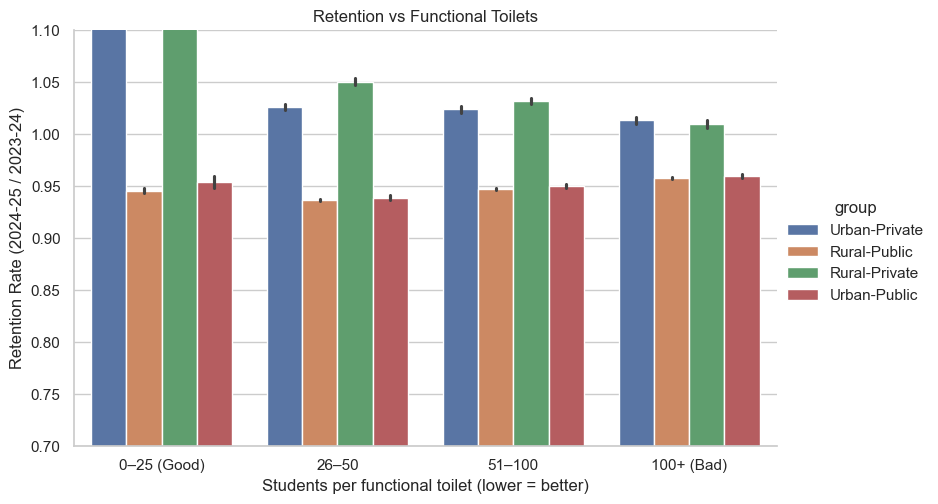

In [7]:
ylims = (0.70, 1.10)

sns.catplot(
    data=analysis_df,
    kind="bar",
    x="toilet_bin",
    y="retention_rate",
    hue="group",
    height=5, aspect=1.6
)
plt.ylim(*ylims)
plt.title("Retention vs Functional Toilets")
plt.ylabel("Retention Rate (2024-25 / 2023-24)")
plt.xlabel("Students per functional toilet (lower = better)")
plt.show()

analysis_df.to_csv("dataset1.csv" , index = False)

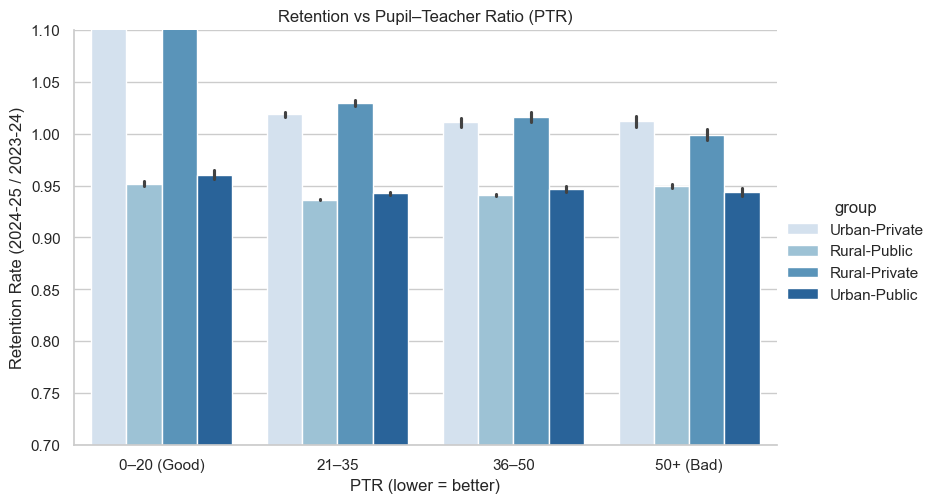

ANALYSIS COMPLETE


In [8]:
sns.catplot(
    data=analysis_df,
    kind="bar",
    x="ptr_bin",
    y="retention_rate",
    hue="group",
    height=5, aspect=1.6,
    palette="Blues"
)
plt.ylim(0.70, 1.10)
plt.title("Retention vs Pupil–Teacher Ratio (PTR)")
plt.ylabel("Retention Rate (2024-25 / 2023-24)")
plt.xlabel("PTR (lower = better)")
plt.show()

print("ANALYSIS COMPLETE")


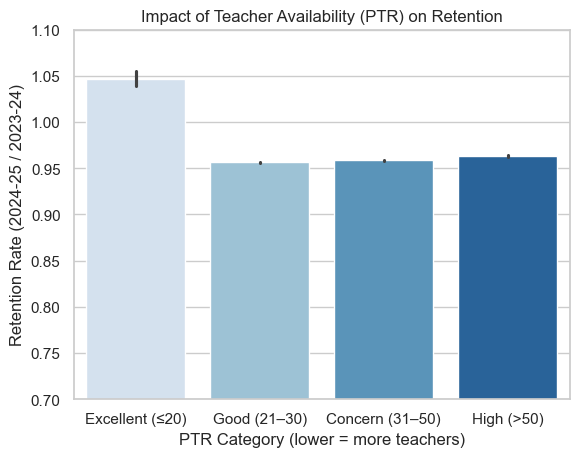

In [9]:
#PLOT:PTR vs Retention

df['ptr_bin'] = pd.cut(
    df['PTR'],
    bins=[0, 20, 30, 50, np.inf],
    labels=['Excellent (≤20)', 'Good (21–30)', 'Concern (31–50)', 'High (>50)'],
    right=False
)

sns.barplot(
    data=df,
    x='ptr_bin',
    y='retention_rate',
    palette='Blues'
)

plt.ylabel('Retention Rate (2024-25 / 2023-24)')
plt.xlabel('PTR Category (lower = more teachers)')
plt.title("Impact of Teacher Availability (PTR) on Retention")
plt.ylim(0.70, 1.10)
plt.show()
df.to_csv("dataset2" , index = False)

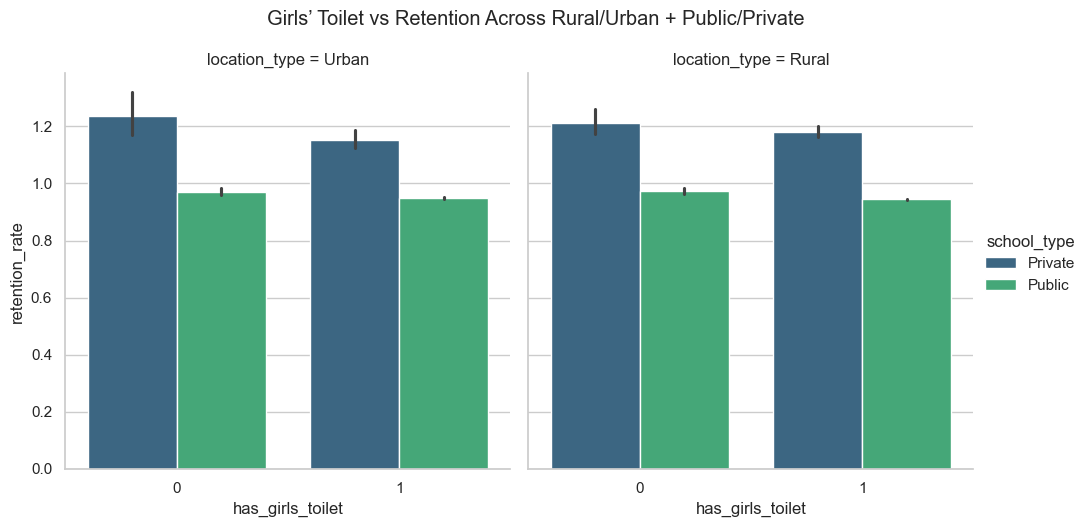


Average functional girls toilets (Rural/Urban + Public/Private):

location_type school_type  avg_girls_functional_toilets
        Rural     Private                      2.690120
        Rural      Public                      1.411160
        Urban     Private                      4.378895
        Urban      Public                      3.028340

Conclusion:
Rural Private schools average 2.69 functional girls toilets.
Rural Public schools average 1.41 functional girls toilets.
Urban Private schools average 4.38 functional girls toilets.
Urban Public schools average 3.03 functional girls toilets.


In [10]:
#Girls' toilet availability vs retention (Public/Private in Rural & Urban)
#+ Average girls' functional toilets for each category


#Create binary column (0 = no girls toilet, 1 = at least 1)
df["has_girls_toilet"] = (df["total_girls_func_toilet"].fillna(0) > 0).astype(int)

# Plot segmented by Rural/Urban + Public/Private
sns.catplot(
    data=df[df["location_type"].isin(["Rural", "Urban"])],
    kind='bar',
    x='has_girls_toilet',
    y='retention_rate',
    col='location_type',
    hue='school_type',
    palette='viridis',
)
plt.suptitle("Girls’ Toilet vs Retention Across Rural/Urban + Public/Private", y=1.05)
plt.show()

#Compute AVERAGE girls toilets for Rural/Urban + Public/Private
avg_girls_toilet_combo = (
    df.groupby(["location_type", "school_type"])["total_girls_func_toilet"]
      .mean()
      .reset_index()
      .rename(columns={"total_girls_func_toilet": "avg_girls_functional_toilets"})
)

print("\nAverage functional girls toilets (Rural/Urban + Public/Private):\n")
print(avg_girls_toilet_combo.to_string(index=False))

#Auto conclusion
print("\nConclusion:")
for _, row in avg_girls_toilet_combo.iterrows():
    print(f"{row['location_type']} {row['school_type']} schools average {row['avg_girls_functional_toilets']:.2f} functional girls toilets.")
    
df[df["location_type"].isin(["Rural", "Urban"])].to_csv("dataset3", index=False)

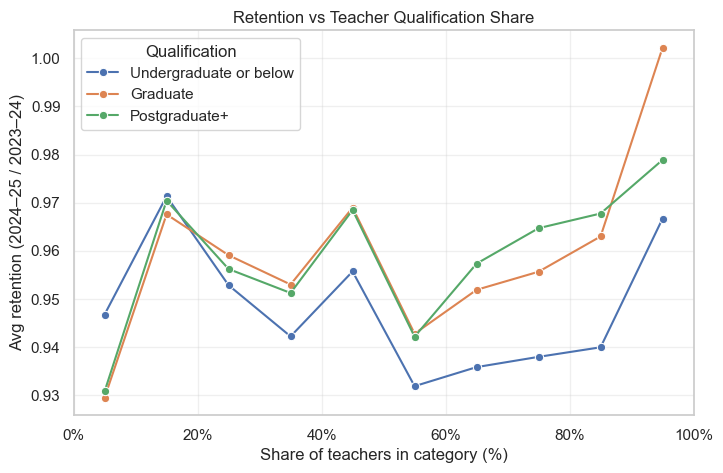

Correlation with retention – Undergrad or below: -0.038
Correlation with retention – Graduate: 0.003
Correlation with retention – Postgraduate+: 0.031


In [11]:
#QUALIFICATION vs RETENTION (three levels)

for c in ['below_graduate','graduate','post_graduate_and_above']:
    if c not in df.columns:
        df[c] = 0

qual_df = df.copy()

#total qualified headcount used for shares
qual_df['teacher_qualified_total'] = (
    pd.to_numeric(qual_df['below_graduate'], errors='coerce').fillna(0) +
    pd.to_numeric(qual_df['graduate'], errors='coerce').fillna(0) +
    pd.to_numeric(qual_df['post_graduate_and_above'], errors='coerce').fillna(0)
)

#keep schools that actually have at least one teacher with a recorded qualification
qual_df = qual_df[qual_df['teacher_qualified_total'] > 0].copy()

#compute shares in [0,1]
qual_df['pct_below_grad'] = (qual_df['below_graduate'] / qual_df['teacher_qualified_total']).clip(0,1)
qual_df['pct_grad']       = (qual_df['graduate'] / qual_df['teacher_qualified_total']).clip(0,1)
qual_df['pct_postgrad']   = (qual_df['post_graduate_and_above'] / qual_df['teacher_qualified_total']).clip(0,1)

#keep sane retention band
qual_df = qual_df[qual_df['retention_rate'].between(0.3, 1.5)]

#long format for 3 categories
long = qual_df[['retention_rate','pct_below_grad','pct_grad','pct_postgrad']].melt(
    id_vars='retention_rate',
    value_vars=['pct_below_grad','pct_grad','pct_postgrad'],
    var_name='qualification', value_name='share'
)

#bin share into 0–100% (10% steps), aggregate mean retention
edges = np.linspace(0, 1, 11)
labels = [f"{int(l*100)}–{int(r*100)}%" for l, r in zip(edges[:-1], edges[1:])]
label_to_mid = {lab: (l+r)/2 for lab, l, r in zip(labels, edges[:-1], edges[1:])}

long['share_bin'] = pd.cut(long['share'], bins=edges, labels=labels, include_lowest=True, right=False)
agg = (long.groupby(['qualification','share_bin'], observed=True)['retention_rate']
           .mean().reset_index())

#pretty names + numeric midpoints for the x-axis
name_map = {
    'pct_below_grad': 'Undergraduate or below',
    'pct_grad': 'Graduate',
    'pct_postgrad': 'Postgraduate+'
}
agg['qualification'] = agg['qualification'].map(name_map)
agg['share_mid'] = agg['share_bin'].map(label_to_mid)  # float in [0,1]

#plot all three lines together
plt.figure(figsize=(8,5))
sns.lineplot(data=agg, x='share_mid', y='retention_rate',
             hue='qualification', marker='o')
plt.xlabel('Share of teachers in category (%)')
plt.xticks(np.linspace(0,1,6), [f"{int(x*100)}%" for x in np.linspace(0,1,6)])
plt.ylabel('Avg retention (2024–25 / 2023–24)')
plt.title('Retention vs Teacher Qualification Share')
plt.grid(alpha=0.3)
plt.legend(title='Qualification')
plt.show()

#correlations
for col, nice in [('pct_below_grad','Undergrad or below'),
                  ('pct_grad','Graduate'),
                  ('pct_postgrad','Postgraduate+')]:
    corr = qual_df[[col,'retention_rate']].corr().iloc[0,1]
    print(f"Correlation with retention – {nice}: {corr:.3f}")

agg.to_csv("dataset4" , index = False)